# 1.Prepare section

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda


# 2.Transform section

In [ ]:
def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image, dtype=np.uint8)
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    return new_image

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 3.Dataset section

I will use given dataset in this notebook, so this section is no in use

# 4.Model section

In [ ]:
class BasicBlock(nn.Module):
    """
    (conv, batchnorm, relu)*2の簡単なCNN
    ResNetを想定して途中にショートカットを仕込んでいる
    expansion=1
    """
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        # 入力と出力の次元が等しくない場合は、1x1の畳み込み層を使って次元を変える
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
            
    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [ ]:
class Bottleneck(nn.Module):
    """
    論文で提案されているBottleNeckを使用。リソース節約。
    """
    expansion = 4
    
    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    """
    ResNetの構造を定義する
    """

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # 最初のblockのみstrideをそのまま適用する,以降は1
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [ ]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

# 5.Main function section

In [ ]:
def train_net(net, train_loader, eval_loader, optim_cls=optim.SGD, loss_fn=nn.CrossEntropyLoss(), n_iter=20, device= 'cpu'):
    optimizer = optim_cls(net.parameters(), lr=0.1)
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    n = 0
    n_acc = 0
    net = net.to(device)

    for epoch in range(n_iter):
        running_loss=0.0
        net.train()
        with tqdm.tqdm(train_loader) as pbar:
            for i, (x, label) in enumerate(pbar):
                x = x.to(device)
                label = label.to(device)
                h = net(x)
                loss = loss_fn(h, label)
                running_loss+=loss.item()
                n += len(label)
                _, y_pred = h.max(1)
                n_acc += (y_pred==label).float().sum().item()

                # 逆伝播によるパラメータ更新
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar.set_postfix(OrderedDict(
                    epoch= epoch+1,
                    loss=running_loss/(i+1), 
                    ))
            train_losses.append(running_loss / len(train_loader))
            train_acc.append(n_acc / n)
            val_loss, val_acc_ = val_net(net, eval_loader, loss_fn, device=device)
            val_losses.append(val_loss)
            val_acc.append(val_acc_)

    return train_losses, val_losses, train_acc, val_acc

def val_net(net, val_loader, loss_fn, device= 'cpu'):
    net.eval()
    val_acc = 0
    val_loss = 0
    n = 0
    n_acc =0
    running_loss=0.0
    net = net.to(device)
    for i, (x, label) in enumerate(val_loader):
        x = x.to(device)
        label = label.to(device)
        h = net(x)
        loss = loss_fn(h, label)
        running_loss+=loss.item()
        n += len(label)
        _, y_pred = h.max(1)
        n_acc += (y_pred==label).float().sum().item()
    val_acc = n_acc / n
    val_loss = running_loss / len(val_loader)
    return val_loss, val_acc

def pred_net(net, test_loader, device= 'cpu'):
    y_preds = []
    net = net.to(device)
    for i, x in enumerate(test_loader):
        x = x.to(device)
        h = net(x)
        _, y_pred = h.max(1)
        y_preds.append(y_pred)
    return torch.cat(y_preds,dim=0)

# 6.Train section

In [ ]:
# Transform組み立て済み

# Dataset組み立て
dataset = torchvision.datasets.CIFAR10('./datasets', train=True, 
                                         download=True, transform=transform)
train_size = int(len(dataset)*0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloader組み立て
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, 
                                           shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, 
                                           shuffle=True, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model組み立て
net = ResNet18().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

# MainFunction実行
train_losses, val_losses, train_acc, val_acc= train_net(net, train_loader, val_loader, device=device)


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 391/391 [00:38<00:00, 10.21it/s, epoch=20, loss=0.032]


# 7.Validate section

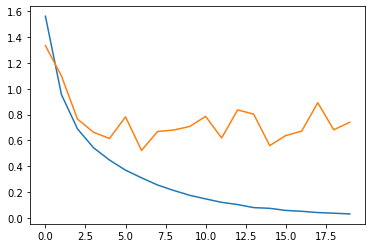

[0.43646, 0.5467, 0.6166, 0.664895, 0.700788, 0.7292733333333333, 0.7526485714285714, 0.772275, 0.7892577777777777, 0.804116, 0.8173090909090909, 0.8290066666666667, 0.8393692307692308, 0.8488985714285714, 0.85726, 0.864925, 0.8718211764705882, 0.8781344444444444, 0.8838684210526315, 0.889129]
[0.5244, 0.6059, 0.7347, 0.7709, 0.79, 0.7582, 0.8299, 0.801, 0.8061, 0.7961, 0.7903, 0.8269, 0.7968, 0.8155, 0.8565, 0.8371, 0.8426, 0.8089, 0.8442, 0.8379]


In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()
print(train_acc)
print(val_acc)

# 8.Test section

In [ ]:
# Transform組み立て済み

# Dataset組み立て
test_set = torchvision.datasets.CIFAR10('./datasets', train=False, 
                                        download=True, transform=transform)

# Dataloader組み立て
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, 
                                          shuffle=False, num_workers=4)

# Model組み立て済み

# MainFunction実行
y_preds = pred_net(net, test_loader)

# Postprocess
print(y_preds)